Objetivo do notebook -> identificar a taxa de aprovação dos professores baseado no tempo de ensino deles na universidade

integrantes ->  FELIPE XAVIER DE ALBUQUERQUE
            -> LUCIANO EDUARDO DANTAS BEZERRA FILHO
            -> PAULO VICTOR GOMES DE SOUSA
   
primeira parte do notebook serve só para adicionar os datasets e filtrar os componentes curriculares para os que pertençam ao IMD/DIMAP

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

profs = pd.read_csv("docentes.csv",sep=";")

matriculas = pd.read_csv("matricula-componente-20172.csv",sep=";")

turmas = pd.read_csv("turmas-20172.csv",sep=";",usecols=["id_turma","id_componente_curricular","codigo_turma","id_docente_interno","local","situacao_turma"])
turmas = turmas.dropna(axis=0)

componentes = pd.read_csv("componentes-curriculares-presenciais.csv",sep=";",usecols=["id_componente","codigo","nome","unidade_responsavel"],error_bad_lines=False)
componentes = componentes.dropna(axis=0)

comp_imd = pd.DataFrame()#dataframe responsavel por ter componentes do imd
comp_imd = componentes[componentes['unidade_responsavel'].str.contains("METROPOLE DIGITAL")]
comp_dimap = componentes[componentes['unidade_responsavel'].str.contains("MATEMÁTICA APLICADA")]

frames = [comp_imd,comp_dimap]#frames dos comp do dimap e do imd
comp_imd = pd.concat(frames)#juntando os componentes do dimap e do imd no imd

comp_imd.to_csv("comp_imd.csv",sep=";",index=False)

comp_imd.id_componente = comp_imd.id_componente.astype(int)#para permitir a comparacao com os valores das tabelas...
#nao criadas artificialmente cujos dtypes sao diferentes de Object


Começando a união das tabelas, yyy é a tabela que reunirá todas as outras ( nome da variável poderia ser um mais adequado mas este está funcionando então... melhor não mecher)

filtrando as turmas para só as que funcionam no IMD

tabelas a serem unidas = Turmas + Docentes + Componentes

In [4]:
yyy = turmas.dropna(axis=0)

yyy = yyy[yyy['local'].str.contains("CIVT")]

yyy['id_docente_interno']= yyy['id_docente_interno'].astype(int)

#adicionando tabela de professores a tabela de turmas
yyy['prof_nome'] = 'nope'
yyy['tempo_servico'] = 'nope'
for index,row in yyy.iterrows():
    for id2, r2 in profs.iterrows():
        if row['id_docente_interno'] == r2['id_servidor']:
            yyy.loc[index,'prof_nome'] = r2['nome']
            yyy.loc[index,'tempo_servico'] = r2['admissao']
            
#adicionando tabela de componentes do imd/dimap na tabela de turmas            
yyy['nome_materia'] = 'nope'
for idx1,row1 in yyy.iterrows():
    for idx2, row2 in comp_imd.iterrows():
        if row1['id_componente_curricular'] == row2['id_componente']:
            yyy.loc[idx1,'nome_materia'] = row2['nome']
            

yyy = yyy[yyy['situacao_turma'].str.contains("CONSOLIDADA")]#caso queira pegar so as turmas consolidadas
yyy.head()


,id_turma,codigo_turma,id_docente_interno,id_componente_curricular,local,situacao_turma,prof_nome,tempo_servico,nome_materia
6920,57606915,01,5752467,2022854,A303 - CIVT,CONSOLIDADA,EDGARD DE FARIA CORREA,2009-03-27 00:00:00,CIRCUITOS LÓGICOS
6921,57606916,01,5752467,2022855,A303 - CIVT,CONSOLIDADA,EDGARD DE FARIA CORREA,2009-03-27 00:00:00,LABORATÓRIO DE CIRCUITOS LÓGICOS
6928,57606921,01,5754320,40134,B204 - CIVT,CONSOLIDADA,LEONARDO CUNHA DE MIRANDA,2011-07-27 00:00:00,INTERACAO HUMANO-COMPUTADOR
6930,57606923,01,62353,2040950,A303 - CIVT,CONSOLIDADA,SELAN RODRIGUES DOS SANTOS,2006-01-09 00:00:00,COMPUTAÇÃO GRÁFICA I
6932,57606925,01,5758443,2054904,A304 - CIVT,CONSOLIDADA,EVERTON RANIELLY DE SOUSA CAVALCANTE,2016-06-10 00:00:00,BOAS PRÁTICAS DE PROGRAMAÇÃO


Calculando a taxa de aprovação a partir do dataset de matriculas

In [5]:
#Criar um DataFrame com as matriculas do semestre
"""matriculas = pd.read_csv("matricula-componente-20171.csv",sep=';', 
                          usecols=["id_turma","descricao","discente", "unidade"])"""
matriculas = matriculas[['id_turma','descricao','discente']].drop_duplicates()
#Tabela pivot com a id das turmas como indice e o numero de alunos para cada valor de descricão(aprovado, reprovado etc.)
matricula_pivot = matriculas.pivot_table(index=["id_turma"], columns="descricao", values=["discente"], aggfunc="count").fillna(0)
#Adiciona coluna com o numero total de alunos inscritos na turma
matricula_pivot['total'] = matricula_pivot.sum(axis=1)
#Separa apenas aqueles que foram aprovados
index = matricula_pivot.index
aprovados = matricula_pivot.loc[index,(slice(None),['APROVADO', 'APROVADO POR NOTA'])].sum(axis=1)
matricula_pivot['total_aprovados'] = aprovados
#descobre o valor para a taxa de aprovação de cada turma
aprovacao = aprovados / matricula_pivot['total']
matricula_pivot['aprovacao'] = aprovacao
#Manter no dataframe apenas os valores relevantes
matricula_pivot.columns = matricula_pivot.columns.droplevel(1)
#matricula_pivot = matricula_pivot.drop(columns=['discente'])

matricula_pivot = matricula_pivot[['total_aprovados','total','aprovacao']]

#criando uma coluna para os indices da tabela pivo
matricula_pivot['indices'] = "nope"

iterador = 0
for idx,row in matricula_pivot.iterrows():
    matricula_pivot.loc[idx,'indices'] = matricula_pivot.index.values[iterador]
    iterador = iterador + 1
    
matricula_pivot.head()

,total_aprovados,total,aprovacao,indices
id_turma,,,,
57602444,0.0,81.0,0.000000,57602444
57602445,79.0,86.0,0.918605,57602445
57602446,76.0,84.0,0.904762,57602446
57602447,0.0,82.0,0.000000,57602447
57602448,0.0,78.0,0.000000,57602448


Unindo a tabela yyy ( a geral ) com a tabela de matriculas para ter a aprovacao dos alunos por turma

resultando na tabela yyy que possuí = turmas + matrículas + componentes curriculares + docentes

In [6]:
yyy['qtd_alunos'] = "nope"
yyy['aprovados'] = "nope"
yyy['perc_aprovacao'] = "nope"

#relacionando a tabela de aprovacoes com a tabela de turmas do imd/dimap
for idx1,row1 in yyy.iterrows():
    for idx2,row2 in matricula_pivot.iterrows():
        if row1['id_turma'] == row2['indices']:
            yyy.loc[idx1,'qtd_alunos'] = row2['total']
            yyy.loc[idx1,'aprovados'] = row2['total_aprovados']
            yyy.loc[idx1,'perc_aprovacao'] = row2['aprovacao']
            
yyy.head()

,id_turma,codigo_turma,id_docente_interno,id_componente_curricular,local,situacao_turma,prof_nome,tempo_servico,nome_materia,qtd_alunos,aprovados,perc_aprovacao
6920,57606915,01,5752467,2022854,A303 - CIVT,CONSOLIDADA,EDGARD DE FARIA CORREA,2009-03-27 00:00:00,CIRCUITOS LÓGICOS,33,12,0.363636
6921,57606916,01,5752467,2022855,A303 - CIVT,CONSOLIDADA,EDGARD DE FARIA CORREA,2009-03-27 00:00:00,LABORATÓRIO DE CIRCUITOS LÓGICOS,33,9,0.272727
6928,57606921,01,5754320,40134,B204 - CIVT,CONSOLIDADA,LEONARDO CUNHA DE MIRANDA,2011-07-27 00:00:00,INTERACAO HUMANO-COMPUTADOR,14,14,1
6930,57606923,01,62353,2040950,A303 - CIVT,CONSOLIDADA,SELAN RODRIGUES DOS SANTOS,2006-01-09 00:00:00,COMPUTAÇÃO GRÁFICA I,26,21,0.807692
6932,57606925,01,5758443,2054904,A304 - CIVT,CONSOLIDADA,EVERTON RANIELLY DE SOUSA CAVALCANTE,2016-06-10 00:00:00,BOAS PRÁTICAS DE PROGRAMAÇÃO,45,24,0.533333


Exportando o dataframe para um csv para acesso mais fácil e removendo todos os NaN's = 'nopes' e deixando só turmas consolidadas

In [7]:
#Codigo para gerar tabelas resultantes desde 20172 ate 20152
csv_export = yyy[yyy['situacao_turma'] == "CONSOLIDADA"]
csv_export = yyy[yyy['prof_nome'] != "nope"]
csv_export = yyy[yyy['perc_aprovacao'] != "nope"]

csv_export.to_csv("20172_resultado.csv",sep=";",index=False,encoding="utf-8")

csv_export

,id_turma,codigo_turma,id_docente_interno,id_componente_curricular,local,situacao_turma,prof_nome,tempo_servico,nome_materia,qtd_alunos,aprovados,perc_aprovacao
6920,57606915,01,5752467,2022854,A303 - CIVT,CONSOLIDADA,EDGARD DE FARIA CORREA,2009-03-27 00:00:00,CIRCUITOS LÓGICOS,33,12,0.363636
6921,57606916,01,5752467,2022855,A303 - CIVT,CONSOLIDADA,EDGARD DE FARIA CORREA,2009-03-27 00:00:00,LABORATÓRIO DE CIRCUITOS LÓGICOS,33,9,0.272727
6928,57606921,01,5754320,40134,B204 - CIVT,CONSOLIDADA,LEONARDO CUNHA DE MIRANDA,2011-07-27 00:00:00,INTERACAO HUMANO-COMPUTADOR,14,14,1
6930,57606923,01,62353,2040950,A303 - CIVT,CONSOLIDADA,SELAN RODRIGUES DOS SANTOS,2006-01-09 00:00:00,COMPUTAÇÃO GRÁFICA I,26,21,0.807692
6932,57606925,01,5758443,2054904,A304 - CIVT,CONSOLIDADA,EVERTON RANIELLY DE SOUSA CAVALCANTE,2016-06-10 00:00:00,BOAS PRÁTICAS DE PROGRAMAÇÃO,45,24,0.533333
6933,57606926,01,5754320,2054906,B204 - CIVT,CONSOLIDADA,LEONARDO CUNHA DE MIRANDA,2011-07-27 00:00:00,ANÁLISE E PROJETO ORIENTADO A OBJETOS,30,20,0.666667
6934,57606927,01,5751828,2054905,A304 - CIVT,CONSOLIDADA,MARCEL VINICIUS MEDEIROS OLIVEIRA,2008-07-14 00:00:00,LÓGICA APLICADA A ENGENHARIA DE SOFTWARE,25,16,0.64
6935,57606928,01,22764,2054912,A305 - CIVT,CONSOLIDADA,JAIR CAVALCANTI LEITE,1993-04-01 00:00:00,PROJETO DE INTERFACES DE USUÁRIO,77,38,0.493506
6936,57606929,01,5752649,2054915,A309 - CIVT,CONSOLIDADA,ROBERTA DE SOUZA COELHO,2009-07-01 00:00:00,TESTE DE SOFTWARE II,10,9,0.9
6937,57606930,01,22764,2054917,A309 - CIVT,CONSOLIDADA,JAIR CAVALCANTI LEITE,1993-04-01 00:00:00,ARQUITETURA DE SOFTWARE,26,19,0.730769


plotando os resultados da porcentagem de aprovacao das turmas filtrando por professor e relacionando com o semestre

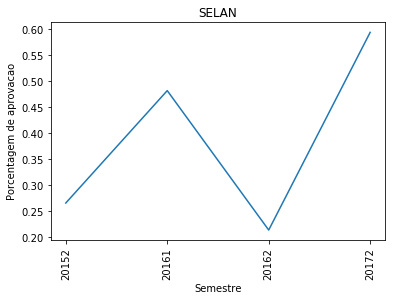

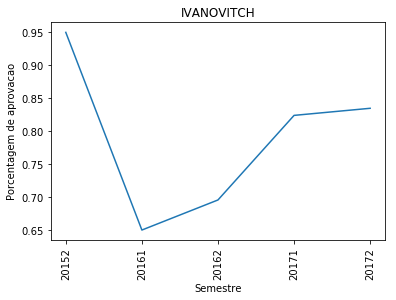

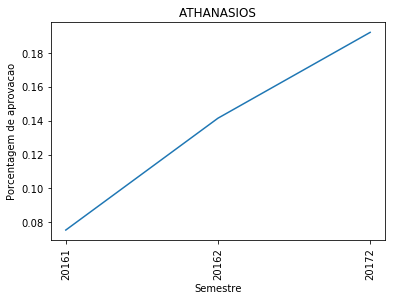

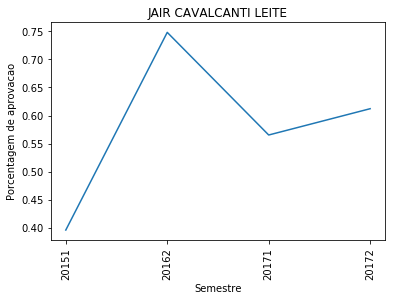

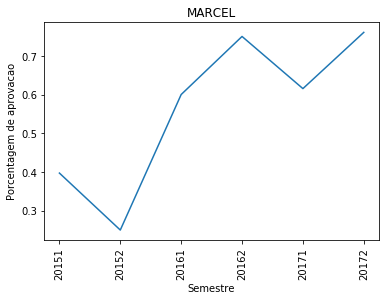

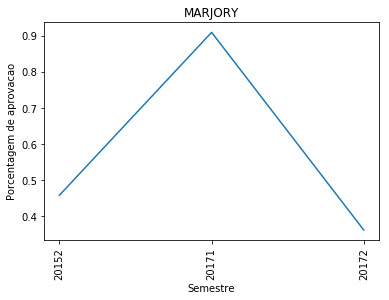

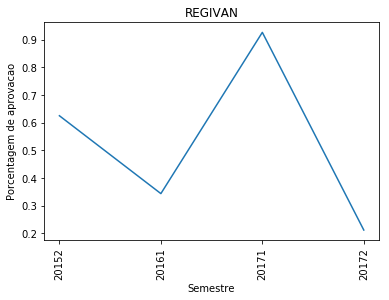

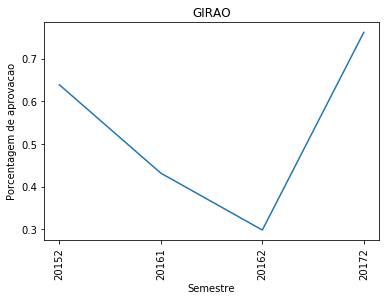

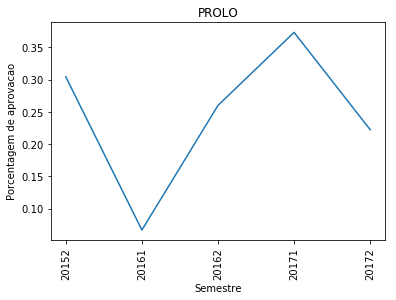

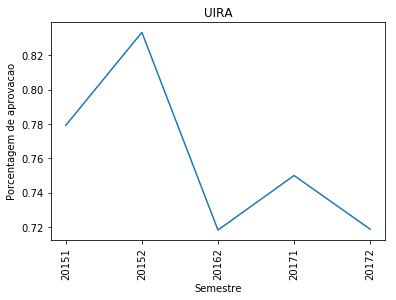

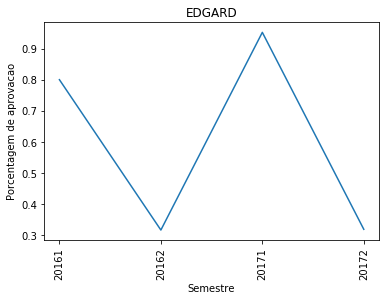

In [140]:
pd.options.mode.chained_assignment = None #removendo warning de copia no assigment do pandas
%matplotlib inline

#datasets resultantes dos semestres anteriores no imd
res20172 = pd.read_csv("20172_resultado.csv",sep=";",encoding="utf-8")
res20171 = pd.read_csv("20171_resultado.csv",sep=";",encoding="utf-8")
res20162 = pd.read_csv("20162_resultado.csv",sep=";",encoding="utf-8")
res20161 = pd.read_csv("20161_resultado.csv",sep=";",encoding="utf-8")
res20152 = pd.read_csv("20152_resultado.csv",sep=";",encoding="utf-8")
res20151 = pd.read_csv("20151_resultado.csv",sep=";",encoding="utf-8")

#lista de professores avaliados
names = ['SELAN','IVANOVITCH','ATHANASIOS','JAIR CAVALCANTI LEITE','MARCEL','MARJORY','REGIVAN','GIRAO','PROLO','UIRA'
        ,'EDGARD']

for name in names:
    r1 = res20172.loc[res20172['prof_nome'].str.contains(name)]
    r1['semestre'] = "20172"
    r2 = res20171.loc[res20171['prof_nome'].str.contains(name)]
    r2['semestre'] = "20171"
    r3 = res20162.loc[res20162['prof_nome'].str.contains(name)]
    r3['semestre'] = "20162"
    r4 = res20161.loc[res20161['prof_nome'].str.contains(name)]
    r4['semestre'] = "20161"
    r5 = res20152.loc[res20152['prof_nome'].str.contains(name)]
    r5['semestre'] = "20152"
    r6 = res20151.loc[res20151['prof_nome'].str.contains(name)]
    r6['semestre'] = "20151"

    frames = [r1,r2,r3,r4,r5,r6]
    resultado = pd.concat(frames)
    resultado

    resultado = resultado.groupby(['semestre'])['perc_aprovacao'].mean().reset_index()

    #plotando aprovacoes e semestres por professor
    plt.title(name)
    plt.ylabel("Porcentagem de aprovacao")
    plt.xlabel("Semestre")
    plt.plot(resultado['perc_aprovacao'])

    plt.xticks(range(len(resultado['semestre'])),resultado.semestre,rotation='vertical')
    plt.show()


#resultado
